## Polar Factorization

In [121]:
m = 4
n = 1000
A = np.random.normal(size=(m,m))
A = A @ A.T
Z = np.random.normal(size=(m,n))
X = A @ Z

In [122]:
U, S, Vh = np.linalg.svd(X)
A_est = U@np.diag(S**0.5)@U.T
Z_est = np.linalg.solve(A_est,X)

In [123]:
for i in range(m):
    print(np.corrcoef(Z[i], Z_est[i])[0,1])

0.9525186937055486
0.8676442578205105
0.7568359301841838
0.9366256157768863


In [124]:
A.mean(), A_est.mean()

(np.float64(1.8078200656823291), np.float64(3.260464677633661))

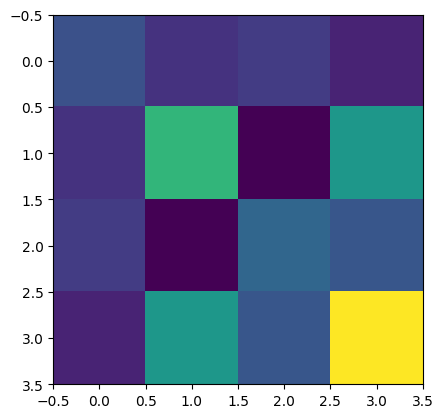

In [125]:
plt.imshow(A)

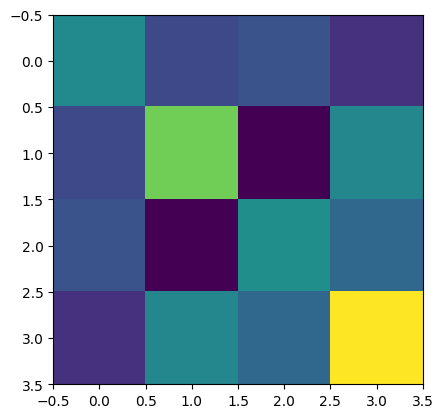

In [126]:
plt.imshow(A_est)

## Normalizing Flow Optimal Transport for Blind Source Separation

In [1]:
import sys
import os 
sys.path.append('../')

import numpy as np
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt 

from utils.jac_tests import check_jac_psd
from utils.nf_models import mGradNet_M, GradNet_M

gpu_idx = 7
if torch.cuda.is_available():
    device = torch.device("cuda:"+str(gpu_idx))
    print("GPU available. Using : " + torch.cuda.get_device_name(gpu_idx))

else:
    device = torch.device("cpu")
    print("GPU not available. Using CPU.")

GPU not available. Using CPU.


In [129]:
## Create Data
torch.manual_seed(11)
train_size = 50000
val_size = 5000
batch_size = 1000

m = torch.randn(2)*5
L = torch.abs(torch.randn(2,2))
M = L @ L.T
#train_latents = torch.from_numpy(np.random.laplace(size=(2,train_size))).float()
train_latents = torch.randn(2,train_size)
train_pts = m[:,None] + M @ train_latents

val_latents = torch.randn(2,val_size)
val_pts = m[:,None] + M @ val_latents

In [130]:
from matplotlib.cm import rainbow
x_min, x_max = train_latents[0].min(), train_latents[0].max()
y_min, y_max = train_latents[1].min(), train_latents[1].max()

X_norm = torch.zeros_like(train_latents.T)
X_norm[:, 0] = (train_latents[0] - x_min) / (x_max - x_min + 1e-8)
X_norm[:, 1] = (train_latents[1] - y_min) / (y_max - y_min + 1e-8)

# Combine x and y into a single scalar for colormap mapping
color_weights = 0.5 * X_norm[:, 0] + 0.5 * X_norm[:, 1]  # weighted average
colors = rainbow(color_weights.cpu())

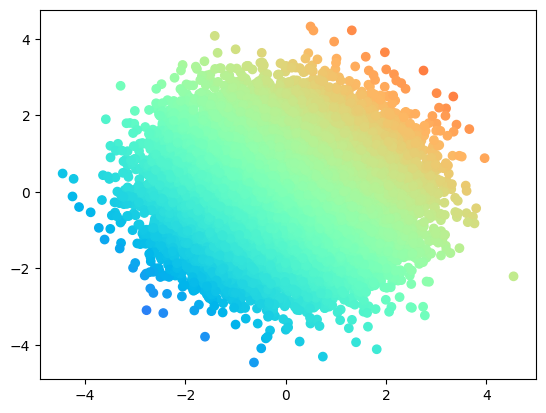

In [131]:
plt.scatter(train_latents[0], train_latents[1], color=colors)

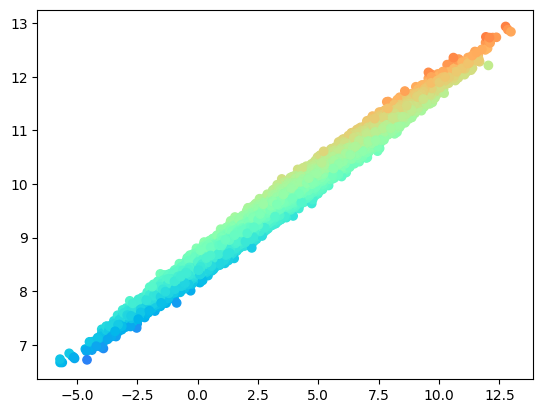

In [132]:
plt.scatter(train_pts[0], train_pts[1], color=colors)

In [133]:
data_loader = DataLoader(TensorDataset(train_pts.T), batch_size=batch_size, shuffle=True, num_workers=8)

In [41]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
import numpy as np

def init_W(embed_dim, in_dim):
    k = np.sqrt(1 / in_dim)
    return 2*k*torch.rand(embed_dim, in_dim) - k

def init_b(embed_dim, in_dim):
    k = np.sqrt(1 / in_dim)
    return 2*k*torch.rand(embed_dim,) - k


class GNM_Module(nn.Module):
    def __init__(self, in_dim, embed_dim, activation):
        super().__init__()

        self.beta = nn.Parameter(torch.rand(1), requires_grad=True)
        self.W = nn.Parameter(init_W(embed_dim, in_dim), requires_grad=True)
        self.b = nn.Parameter(init_b(embed_dim, in_dim), requires_grad=True)
        self.act = activation()

    def forward(self, x):

        z = F.linear(x, weight = self.W, bias=self.b)
        z = self.act(z * F.softplus(self.beta))
        z = F.linear(z, weight=self.W.T)
        
        #J = F.softplus(self.beta) * self.W.T @ J_sigma @ self.W
        return z
    
class mGradNet_M(nn.Module):
    def __init__(self, num_modules, in_dim, embed_dim, activation):
        super().__init__()

        self.num_modules = num_modules
        self.mmgn_modules = nn.ModuleList([GNM_Module(in_dim, embed_dim, activation) for i in range(num_modules)])
        self.alpha = nn.Parameter(torch.rand(num_modules,), requires_grad=True)
        self.bias = nn.Parameter(init_b(in_dim, embed_dim), requires_grad=True)

    def forward(self, x):

        z = 0
        J = 0
        for i in range(self.num_modules):
            out = self.mmgn_modules[i](x)
            J_i = torch.func.vmap(torch.func.jacfwd(self.mmgn_modules[i]))(x)
            J += J_i * F.softplus(self.alpha[i])
            z += F.softplus(self.alpha[i]) * out
        logdet = torch.logdet(J)
        z += self.bias
        return z, logdet


class GradNet_M(nn.Module):
    def __init__(self, num_modules, in_dim, embed_dim, activation):
        super().__init__()

        self.num_modules = num_modules
        self.mmgn_modules = nn.ModuleList([GNM_Module(in_dim, embed_dim, activation) for i in range(num_modules)])
        self.alpha = nn.Parameter(torch.randn(num_modules,), requires_grad=True)
        self.bias = nn.Parameter(init_b(in_dim, embed_dim), requires_grad=True)

    def forward(self, x):
        z = 0
        J = 0
        for i in range(self.num_modules):
            out = self.mmgn_modules[i](x)
            J_i = torch.func.vmap(torch.func.jacfwd(self.mmgn_modules[i]))(x)
            J += J_i * self.alpha[i]
            z += self.alpha[i] * out
        logdet = torch.linalg.slogdet(J).logabsdet
        z += self.bias
        return z, logdet


In [134]:
mgn_m = mGradNet_M(num_modules=4, in_dim=2, embed_dim=2, activation=lambda : nn.Softmax(dim=-1)).to(device) # use learnable activation if desired
print("mGN-M parameters", sum(p.size().numel() for p in mgn_m.parameters() if p.requires_grad))

mGN-M parameters 34


In [135]:
epochs = 150
lr = 5e-3

optimizer = torch.optim.Adam(mgn_m.parameters(), lr=lr)
best_val_loss = float('Inf')

for epoch in range(1,epochs+1):
    avg_train_loss = 0
    for i, (x,) in enumerate(data_loader):
        out, logdet = mgn_m(x.to(device))
        loss = -logdet.sum() + torch.sum(out**2)# torch.sum(torch.abs(out))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_train_loss += loss.item()
    
    avg_train_loss = avg_train_loss / len(data_loader)
    
    with torch.no_grad():
        val_out, lgdt = mgn_m(val_pts.T.to(device))
        val_loss = -lgdt.sum() + torch.sum(val_out**2)# torch.sum(torch.abs(val_out))
    
    #if val_loss < best_val_loss:
    #    best_val_loss = val_loss
    #    torch.save(mgn_m.state_dict(), save_path+'model.pt')
    
    print("Epoch: ", epoch, "Train Loss: ", avg_train_loss, "Val Loss: ", val_loss)

Epoch:  1 Train Loss:  9034.491904296876 Val Loss:  tensor(28992.3887)
Epoch:  2 Train Loss:  5364.7221484375 Val Loss:  tensor(25062.7734)
Epoch:  3 Train Loss:  4776.975986328125 Val Loss:  tensor(22642.0977)
Epoch:  4 Train Loss:  4329.8912890625 Val Loss:  tensor(20532.6777)
Epoch:  5 Train Loss:  3910.1910986328126 Val Loss:  tensor(18423.6699)
Epoch:  6 Train Loss:  3482.1552197265623 Val Loss:  tensor(16258.6182)
Epoch:  7 Train Loss:  3049.056396484375 Val Loss:  tensor(14116.7344)
Epoch:  8 Train Loss:  2629.911865234375 Val Loss:  tensor(12082.0957)
Epoch:  9 Train Loss:  2239.738154296875 Val Loss:  tensor(10226.1602)
Epoch:  10 Train Loss:  1886.9519116210938 Val Loss:  tensor(8560.6953)
Epoch:  11 Train Loss:  1573.6216162109374 Val Loss:  tensor(7106.2754)
Epoch:  12 Train Loss:  1301.6211450195312 Val Loss:  tensor(5829.5088)
Epoch:  13 Train Loss:  1067.5450305175782 Val Loss:  tensor(4761.9668)
Epoch:  14 Train Loss:  873.8701745605468 Val Loss:  tensor(3871.6875)
Epoc

In [136]:
def is_symmetric(matrix):
    return torch.allclose(matrix, matrix.T, atol=1e-5)

def is_psd(matrix):
    eigvals = torch.linalg.eigvalsh(matrix)
    return eigvals.amin() > -1e-5

def check_jac_psd(model, domain, in_dim, device, num_samples=1000):

    for i in range(num_samples):
        x = (domain[1] - domain[0]) * torch.rand(size=(1,in_dim), device=device) + domain[0]
        J, _ = torch.func.jacrev(model, has_aux=True)(x)
        J = J.squeeze()

        if not is_symmetric(J) or not is_psd(J):
            print('Jacobian PSD Test Failed')
            return 

    print('jacobian PSD Test Passed')
    return 

check_jac_psd(mgn_m, in_dim=2, device=device, domain=[0,1])

jacobian PSD Test Passed


In [137]:
z_est, _ = mgn_m(train_pts.T.to(device))
z_est = z_est.detach().T
train_latents, z_est*1.1

(tensor([[ 0.5486, -0.1880,  0.8822,  ..., -0.3697, -1.3140, -0.3071],
         [-0.9980, -0.2963, -0.5295,  ..., -1.1537, -0.3909, -0.9566]]),
 tensor([[ 0.4528, -0.1046,  0.6989,  ..., -0.2334, -0.9743, -0.1862],
         [-0.7971, -0.2456, -0.4315,  ..., -0.9168, -0.3139, -0.7657]]))

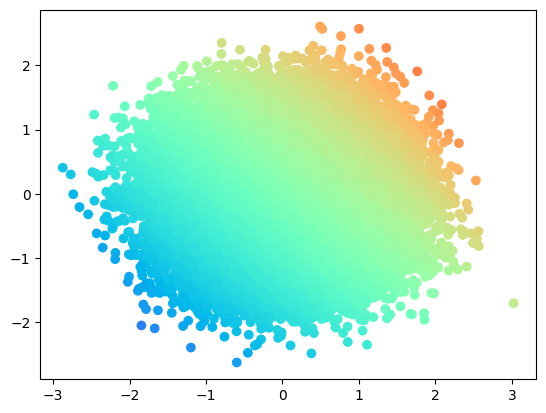

In [138]:
plt.scatter(z_est[0], z_est[1], color=colors)

In [20]:
theta = torch.acos(train_latents[:,0] @ z_est[:,0] / (torch.norm(train_latents[:,0]) * torch.norm(z_est[:,0])))
Q = torch.tensor([[torch.cos(theta), -torch.sin(theta)],[torch.sin(theta), torch.cos(theta)]]).T 
i = -3
Q @ z_est[:,i] * torch.norm(train_latents[:,i]) / torch.norm(z_est[:,i])

tensor([ 0.6361, -1.0311])

In [31]:
i = 100

theta = torch.acos(train_latents[:,i] @ z_est[:,i] / (torch.norm(train_latents[:,i]) * torch.norm(z_est[:,i])))
theta * 180/3.14159265

tensor(74.2912)

## Learning Gradient of a 2-D Convex Function

In [1]:
import sys
import os 
sys.path.append('../')

import numpy as np
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt 

from utils.jac_tests import check_jac_psd
from utils.models import mGradNet_M, mGradNet_C

gpu_idx = 7
if torch.cuda.is_available():
    device = torch.device("cuda:"+str(gpu_idx))
    print("GPU available. Using : " + torch.cuda.get_device_name(gpu_idx))

else:
    device = torch.device("cpu")
    print("GPU not available. Using CPU.")

GPU available. Using : NVIDIA GeForce RTX 2080 Ti


Learning the gradient of the 2d polynomial $F(x_1, x_2) = x_1^4 + \frac{x_1^2}{2} + \frac{x_1 x_2}{2} + \frac{3x_2^2}{2} - \frac{x_2^3}{3}$ which is convex on the unit square

This benchmark polynomial proposed in https://arxiv.org/pdf/2111.12187

In [2]:
# The convex function 
def convex_function(x, y):
    return x**4 + (x**2)/2 + (x*y)/2 + 3*(y**2)/2 - (y**3)/3

# The gradient of the convex function
def field(z):
    x = z[:,0]
    y = z[:,1]
    return torch.stack([4*x**3 + 0.5*y + x, 3*y - y**2 + 0.5*x ]).T

/home/shreyasc/miniconda3/envs/py311/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449183005/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


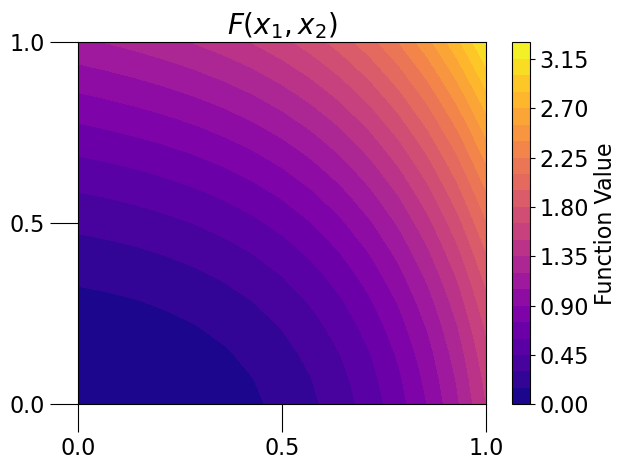

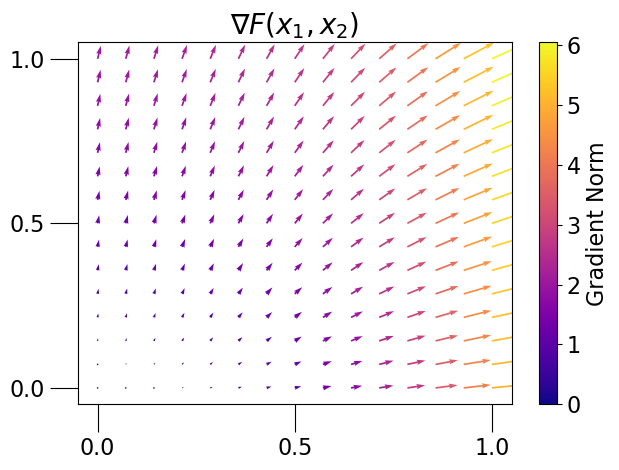

In [3]:
x = torch.linspace(0, 1, 15)
y = torch.linspace(0, 1, 15)

X, Y = torch.meshgrid(x, y)
space = torch.cat([torch.reshape(X,(-1,1)),torch.reshape(Y,(-1,1))],1)
grad = field(space)

label_size = 16
title_size= 20
cmap = 'plasma'
levels = 30

# Create contour plot
plt.figure()
plt.contourf(x, y, convex_function(space[:,0], space[:,1]).view(x.numel(),x.numel()).T, levels=levels, cmap=cmap)
plt.xticks([0, 0.5, 1.0])
plt.yticks([0, 0.5, 1.0])
plt.title(r'$F(x_1, x_2)$', size=title_size)
plt.tick_params(axis='both', length=20, which='major', labelsize=label_size)
cbar = plt.colorbar()
cbar.set_label('Function Value', fontsize=label_size)
cbar.ax.tick_params(labelsize=label_size) 
plt.tight_layout()
plt.show()
plt.close()

# Create quiver plot of the gradient
plt.figure()
p = plt.quiver(space[:,0], space[:,1], grad[:,0], grad[:,1], grad.norm(dim=-1), cmap=cmap)
plt.xticks([0, 0.5, 1.0])
plt.yticks([0, 0.5, 1.0])
plt.title(r'$\nabla F(x_1, x_2)$', size=title_size)
plt.tick_params(axis='both', length=20, which='major', labelsize=label_size)
cbar = plt.colorbar(p)
cbar.set_label('Gradient Norm', fontsize=label_size)
cbar.ax.tick_params(labelsize=label_size) 
plt.tight_layout()
plt.show()
plt.close()

### Train mGradNets to learn $\nabla F(x_1, x_2)$

In [6]:
## Training parameters 
epochs = 200
lr = 5e-3
train_size = 100000
val_size = 10000
batch_size = 1000
criterion = nn.MSELoss()
num_trials = 5
seed = 42

def train_model(model, data_loader, val_pts, field, save_path):

    # Check if the directory exists, create it if not
    if not os.path.exists(save_path):
        os.makedirs(save_path)
        print(f"Directory '{save_path}' created.")
    else:
        print(f"Directory '{save_path}' already exists.")

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_val_loss = float('Inf')

    for epoch in range(1,epochs+1):
        avg_train_loss = 0
        for i, (x, y) in enumerate(data_loader):
            out = model(x.to(device))
            loss = criterion(out, y.to(device))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            avg_train_loss += loss.item()
        
        avg_train_loss = avg_train_loss / len(data_loader)
        
        with torch.no_grad():
            val_loss = F.mse_loss(model(val_pts.to(device)), field(val_pts).to(device)).item()
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path+'model.pt')
        
        print("Epoch: ", epoch, "Train Loss: ", avg_train_loss, "Val Loss: ", val_loss)
    
    return

In [7]:
### Train mGradNet-C
for trial in range(num_trials):
    torch.manual_seed(seed*trial)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed*trial)
        
    mgn_c = mGradNet_C(num_layers=4, in_dim=2, embed_dim=7, activation=lambda : nn.Tanh()).to(device) # use learnable activation if desired
    print("mGN-C parameters", sum(p.size().numel() for p in mgn_c.parameters() if p.requires_grad))
    train_pts = torch.rand(size=(train_size, 2))
    val_pts = torch.rand(size=(val_size, 2))
    data_loader = DataLoader(TensorDataset(train_pts, field(train_pts)), batch_size=batch_size, shuffle=True, num_workers=8)

    print('TRIAL: ', trial)
    train_model(mgn_c, data_loader=data_loader, val_pts=val_pts, field=field, save_path='./trained_models/convex/mGN-C/trial'+str(trial)+'/')


mGN-C parameters 100
TRIAL:  0
Directory './trained_models/convex/mGN-C/trial0/' already exists.
Epoch:  1 Train Loss:  0.3702660728991032 Val Loss:  0.09148299694061279
Epoch:  2 Train Loss:  0.033087140694260594 Val Loss:  0.007679336238652468
Epoch:  3 Train Loss:  0.005052904200274497 Val Loss:  0.003782800165936351
Epoch:  4 Train Loss:  0.0029051710665225984 Val Loss:  0.0023768062237650156
Epoch:  5 Train Loss:  0.0018808406160678714 Val Loss:  0.0016055511077865958
Epoch:  6 Train Loss:  0.0013255496963392943 Val Loss:  0.0011874119518324733
Epoch:  7 Train Loss:  0.0010284814075566828 Val Loss:  0.0009567037341184914
Epoch:  8 Train Loss:  0.0008494374866131693 Val Loss:  0.0008175527327693999
Epoch:  9 Train Loss:  0.0007164954667678103 Val Loss:  0.00068939063930884
Epoch:  10 Train Loss:  0.000620853592408821 Val Loss:  0.000609431997872889
Epoch:  11 Train Loss:  0.0005461253109388054 Val Loss:  0.0005389210418798029
Epoch:  12 Train Loss:  0.0004846493442892097 Val Loss: 

In [8]:
### Train mGradNet-M
for trial in range(num_trials):
    torch.manual_seed(seed*trial)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed*trial)
        
    mgn_m = mGradNet_M(num_modules=4, in_dim=2, embed_dim=7, activation=lambda : nn.Softmax(dim=-1)).to(device) # use learnable activation if desired
    print("mGN-M parameters", sum(p.size().numel() for p in mgn_m.parameters() if p.requires_grad))
    train_pts = torch.rand(size=(train_size, 2))
    val_pts = torch.rand(size=(val_size, 2))
    data_loader = DataLoader(TensorDataset(train_pts, field(train_pts)), batch_size=batch_size, shuffle=True, num_workers=8)

    print('TRIAL: ', trial)
    train_model(mgn_m, data_loader=data_loader, val_pts=val_pts, field=field, save_path='./trained_models/convex/mGN-M/trial'+str(trial)+'/')

mGN-M parameters 94
TRIAL:  0
Directory './trained_models/convex/mGN-M/trial0/' already exists.
Epoch:  1 Train Loss:  0.8818746429681777 Val Loss:  0.4427316188812256
Epoch:  2 Train Loss:  0.21949871502816676 Val Loss:  0.1344475895166397
Epoch:  3 Train Loss:  0.10446784891188145 Val Loss:  0.07701285183429718
Epoch:  4 Train Loss:  0.049334766548126935 Val Loss:  0.025728868320584297
Epoch:  5 Train Loss:  0.01290992331225425 Val Loss:  0.0052162217907607555
Epoch:  6 Train Loss:  0.0031054538115859033 Val Loss:  0.00204831687733531
Epoch:  7 Train Loss:  0.0017905865306966006 Val Loss:  0.0016220416873693466
Epoch:  8 Train Loss:  0.0015259849221911281 Val Loss:  0.0014335503801703453
Epoch:  9 Train Loss:  0.0013573403528425842 Val Loss:  0.00128376972861588
Epoch:  10 Train Loss:  0.001215459133964032 Val Loss:  0.0011526260059326887
Epoch:  11 Train Loss:  0.0010944859916344285 Val Loss:  0.0010378255974501371
Epoch:  12 Train Loss:  0.0009912390663521363 Val Loss:  0.000942693

### Plot results

In [17]:
# Plot Results
xi = torch.linspace(0, 1, 100)
yi = torch.linspace(0, 1, 100)

Xi, Yi = torch.meshgrid(xi, yi)
space = torch.cat([torch.reshape(Xi,(-1,1)),torch.reshape(Yi,(-1,1))],1)
targ = field(space)

def get_norm_err(model):
    model = model.cpu()
    out = model(space)
    return (targ - out).norm(dim=1).reshape(Xi.shape).T

norm_errs = {'mgn_c':[], 'mgn_m':[]}

# Load trained models
mgn_c = mGradNet_C(num_layers=4, in_dim=2, embed_dim=7, activation=lambda : nn.Tanh()).to(device) # use learnable activation if desired
mgn_m = mGradNet_M(num_modules=4, in_dim=2, embed_dim=7, activation=lambda : nn.Softmax(dim=-1)).to(device) # use learnable activation if desired

# Check that jacobians are PSD
mgn_c.load_state_dict(torch.load('./trained_models/convex/mGN-C/trial0/model.pt'))
mgn_c = mgn_c.to(device)
print("mgn_c params:", sum(p.size().numel() for p in mgn_c.parameters() if p.requires_grad))
check_jac_psd(mgn_c, in_dim=2, device=device, domain=[0,1])

mgn_m.load_state_dict(torch.load('./trained_models/convex/mGN-M/trial0/model.pt'))
mgn_m = mgn_m.to(device)
print("mgn_m params:", sum(p.size().numel() for p in mgn_m.parameters() if p.requires_grad))
check_jac_psd(mgn_m, in_dim=2, device=device, domain=[0,1])

mgn_c params: 100
jacobian PSD Test Passed
mgn_m params: 94
jacobian PSD Test Passed


In [18]:
for t in range(num_trials):
    mgn_c.load_state_dict(torch.load('./trained_models/convex/mGN-C/trial'+str(t)+'/model.pt'))
    mgn_m.load_state_dict(torch.load('./trained_models/convex/mGN-M/trial'+str(t)+'/model.pt'))
    norm_errs['mgn_c'].append(get_norm_err(mgn_c).detach())
    norm_errs['mgn_m'].append(get_norm_err(mgn_m).detach())

for key in norm_errs.keys():
    errs = norm_errs[key]
    errs = torch.stack(errs, dim=0) #(trials, points, dim)
    errs = torch.mean(torch.square(errs.flatten(start_dim=1)), dim=-1)
    errs = 10*torch.log10(errs)

    print('MSE Statistics Across Trials')
    print('Model: ', key, 'Mean (dB): ', errs.mean().item(), 'Std (dB): ', errs.std().item())    

MSE Statistics Across Trials
Model:  mgn_c Mean (dB):  -49.045066833496094 Std (dB):  0.9596526026725769
MSE Statistics Across Trials
Model:  mgn_m Mean (dB):  -48.650794982910156 Std (dB):  4.865450382232666


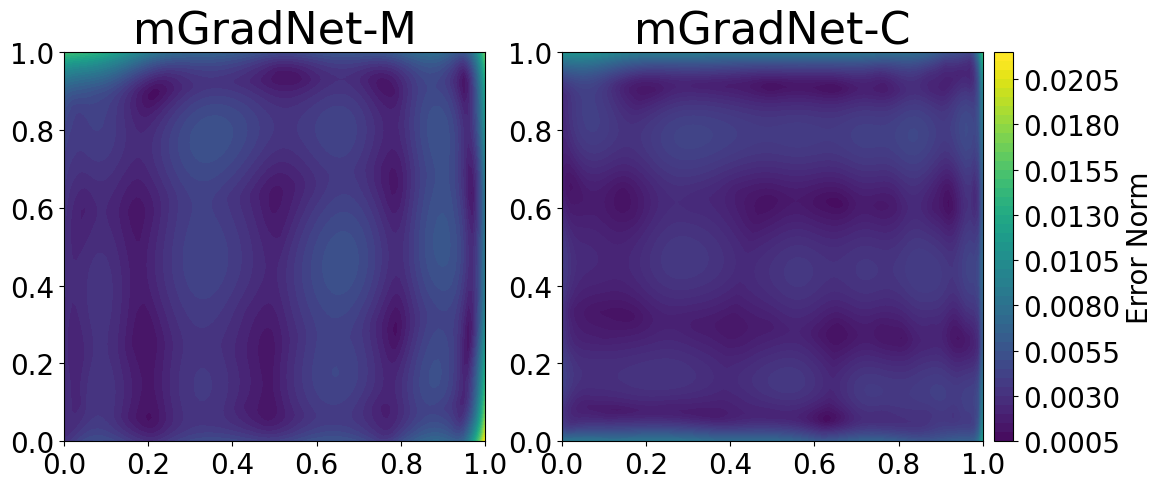

In [30]:
label_size = 20
title_size= 32
cmap = 'plasma'
levels = 50

z_m = torch.stack(norm_errs['mgn_m'],dim=0).mean(dim=0)
z_c = torch.stack(norm_errs['mgn_c'],dim=0).mean(dim=0)

fig, ax = plt.subplots(1, 2, figsize=(12,5))
cmax = max(z_m.amax(), z_c.max())
mgn_m_plt = ax[0].contourf(xi, yi, z_m, levels=levels, cmap=cmap,vmin=0, vmax=cmax)
mgn_c_plt = ax[1].contourf(xi, yi, z_c, levels=levels, cmap=cmap,vmin=0, vmax=cmax)

ax[0].set_title('mGradNet-M',fontsize=title_size)
ax[1].set_title('mGradNet-C',fontsize=title_size)
ax[0].tick_params(axis='both', which='major', labelsize=label_size)
ax[1].tick_params(axis='both', which='major', labelsize=label_size)


plt.tight_layout()
if z_m.amax() > z_c.max():
    cbar = plt.colorbar(mgn_m_plt, ax=ax, pad= 0.01)
else:
    cbar = plt.colorbar(mgn_c_plt, ax=ax, pad= 0.01)
cbar.set_label('Error Norm', fontsize=label_size)
cbar.ax.tick_params(labelsize=label_size) 